# Analyse factorielle des correspondances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import sqlite3 as sql

In [2]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

In [3]:
### Lire le fichier corrigé manuellement – ne pas effacer !

path = 'data/observations_900.csv'

obs = pd.read_csv(path)
obs.set_index('id', inplace=True)
obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti
id,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste
2,31,H,4466,de temps en temps,gauche
3,79,F,7515,trois-quatre fois par semaine,populiste
4,26,H,3376,le week-end,écologiste
5,75,F,3296,trois-quatre fois par semaine,droite


In [5]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
# et coder les années de naissance en relation avec un découpage significatif au point de vue heuristique, et modifiable si besion
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

generations = [18, 26, 36, 46, 56, 66, 91]
c_obs = obs.copy(deep=True)
c_obs['generation'] = pd.cut(c_obs['age'], generations, right=False)
c_obs['generation'] = c_obs['generation'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))\
       .astype(dtype='str')
# Inspection
c_obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti,generation
id,,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste,66-90
2,31,H,4466,de temps en temps,gauche,26-35
3,79,F,7515,trois-quatre fois par semaine,populiste,66-90
4,26,H,3376,le week-end,écologiste,26-35
5,75,F,3296,trois-quatre fois par semaine,droite,66-90


In [6]:
max(c_obs['revenu_mensuel'])

265334

In [7]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
# et coder les années de naissance en relation avec un découpage significatif au point de vue heuristique, et modifiable si besion
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

classes_revenu = [0,3000, 4500, 6000, 8000, 10000, 12000, 300000]
c_obs['classe_revenu'] = pd.cut(c_obs['revenu_mensuel'], classes_revenu, right=False)
c_obs['classe_revenu'] = c_obs['classe_revenu']\
    .apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1)).astype(dtype='str')

# Inspection
c_obs.head()

,age,gender,revenu_mensuel,lecture_journal,parti,generation,classe_revenu
id,,,,,,,
1,87,F,9410,trois-quatre fois par semaine,populiste,66-90,8000-9999
2,31,H,4466,de temps en temps,gauche,26-35,3000-4499
3,79,F,7515,trois-quatre fois par semaine,populiste,66-90,6000-7999
4,26,H,3376,le week-end,écologiste,26-35,3000-4499
5,75,F,3296,trois-quatre fois par semaine,droite,66-90,3000-4499


## Age et orientation politique

### Tableau de contingence

In [10]:
### La fonction pivot_table produit un tableau de contingence
## Au centre du tableau se trouvent les effectifs conjoints, 
## aux bords les effectifs marginaux qui correspondent 
## aux distributions indépendantes des variables

X = "parti"  # "0"
Y = "generation"

ddf = c_obs[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

parti,centre,droite,gauche,populiste,écologiste,Total
generation,,,,,,
18-25,6,5,32,22,45,110
26-35,11,14,27,31,46,129
36-45,22,18,18,18,18,94
46-55,33,9,21,36,32,131
56-65,39,17,15,26,26,123
66-90,57,73,39,106,38,313
Total,168,136,152,239,205,900


In [11]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

parti,centre,droite,gauche,populiste,écologiste
generation,,,,,
18-25,6,5,32,22,45
26-35,11,14,27,31,46
36-45,22,18,18,18,18
46-55,33,9,21,36,32
56-65,39,17,15,26,26
66-90,57,73,39,106,38


In [12]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 6 , 5 ), effectif: 900 , nombre max. facteurs: 4


In [14]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 133.35200723962427 , dof : 20
p-value : 9.136665302058323e-19
phi2 = inertie (variance totale) : 0.14816889693291585
Cramer:  0.20666807779119617


### Commentaire

Noter la petite valeur de p value, on peut rejeter l'hypothèse d'indépendance. 

Le lien n'est pas très fort, mais on profite des axes factoriels pour prendre connaissance des tendances 

In [15]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'),
   row_labels=Index(['18-25', '26-35', '36-45', '46-55', '56-65', '66-90'], dtype='object', name='generation'))

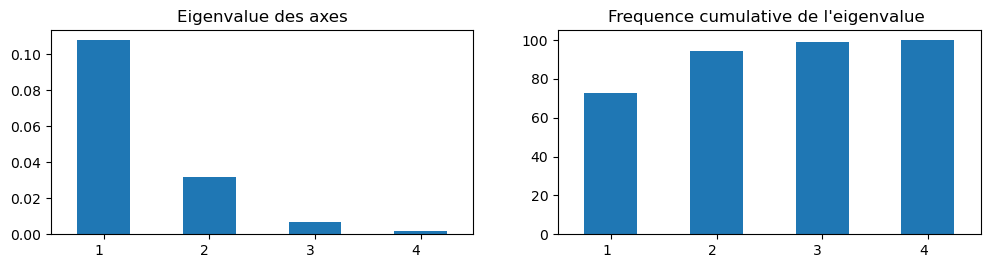

In [16]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Distances des lignes / des colonnes

In [17]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:5]
prof_marg_lig = tot_col/np.sum(tot_col)

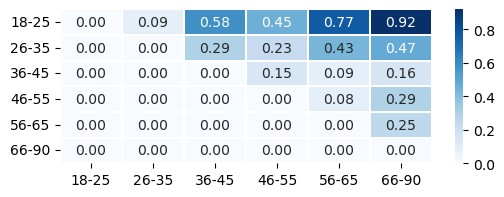

In [18]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente

fig, ax = plt.subplots(figsize=(6,2))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index,
fmt=".2f", annot=True)


### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

In [19]:
# Profil marginal des colonnes
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T

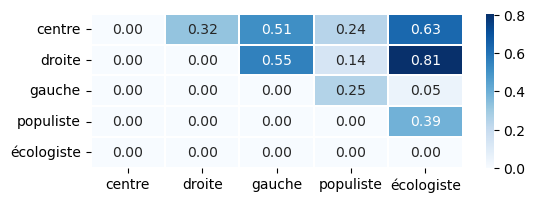

In [20]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  

fig, ax = plt.subplots(figsize=(6,2))


distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".2f", annot=True)

plt.show()

### Graphiques et interprétation du premier plan factoriel

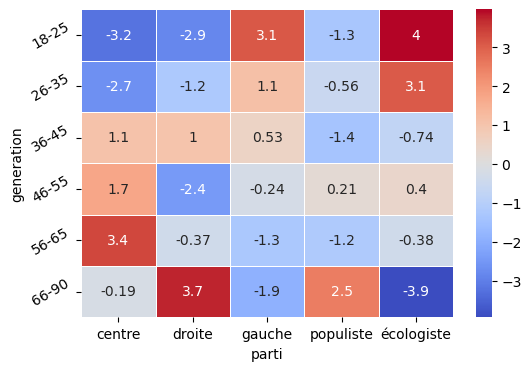

In [21]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


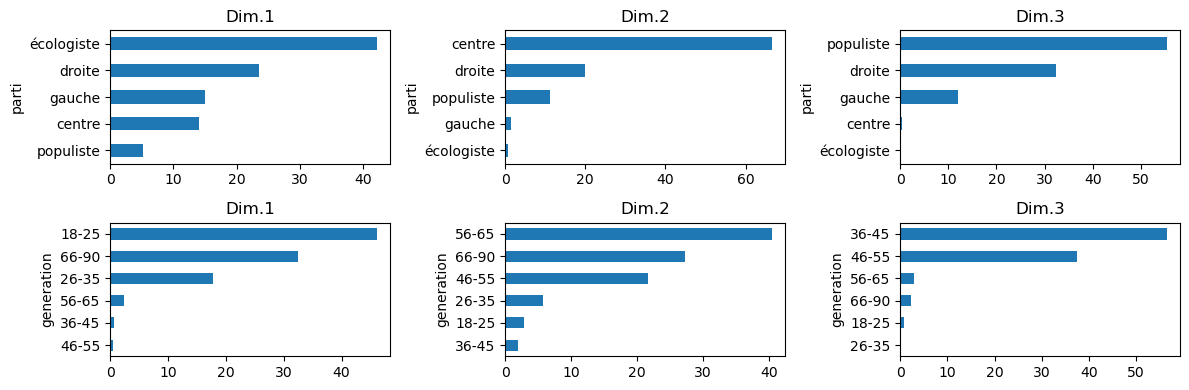

In [30]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


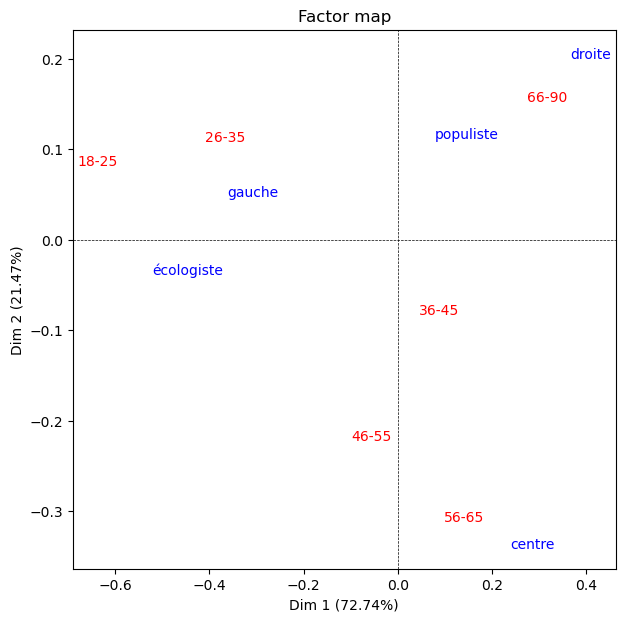

In [31]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

### Représenter l'autre plan factoriel

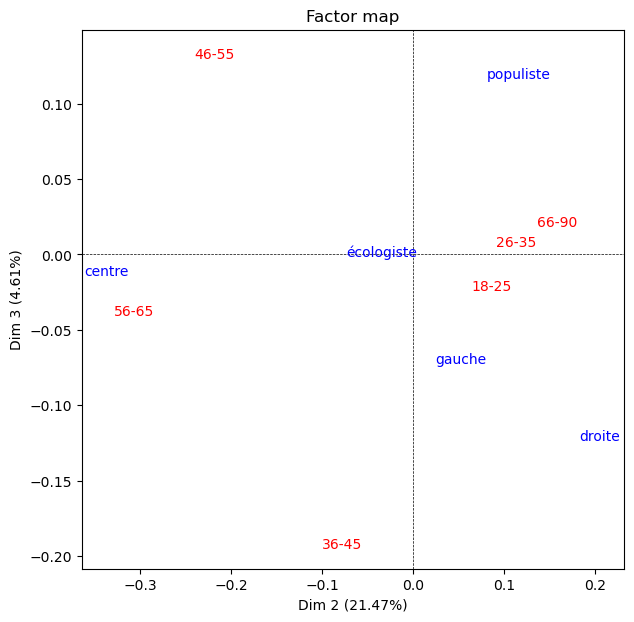

In [32]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(7,7))

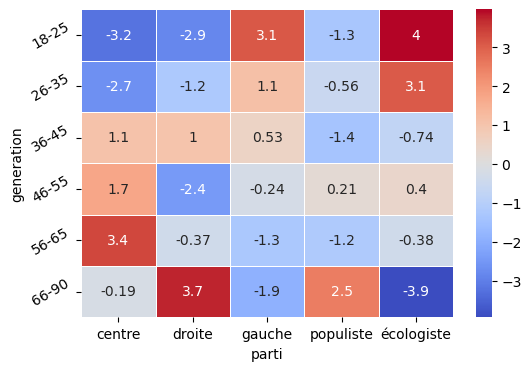

In [33]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


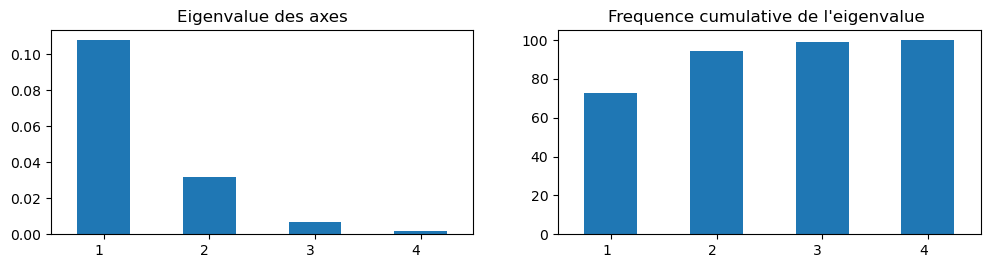

In [ ]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

---------

## Genre et orientation politique

In [34]:
X = "gender"
Y = "parti"  # "0"

ddf = c_obs[[Y,X]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) 
ddf

parti,centre,droite,gauche,populiste,écologiste,Total
gender,,,,,,
F,100,73,97,97,129,496
H,68,63,55,142,76,404
Total,168,136,152,239,205,900


In [35]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

parti,centre,droite,gauche,populiste,écologiste
gender,,,,,
F,100,73,97,97,129
H,68,63,55,142,76


In [36]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 5 ), effectif: 900 , nombre max. facteurs: 1


In [37]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 31.53612635163596 , dof : 4
p-value : 2.3795787064541495e-06
phi2 = inertie (variance totale) : 0.035040140390706624
Cramer:  0.1871901183041098


In [38]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'),
   row_labels=Index(['F', 'H'], dtype='object', name='gender'))

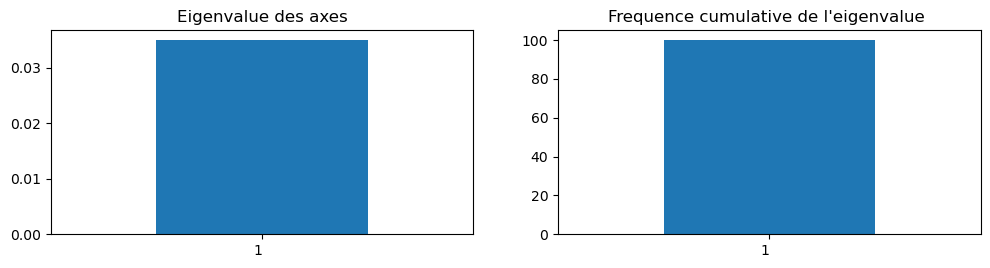

In [39]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Commentaire

Pas la peine de poursuivre, seulement deux modalités pour la variable genre, et un seul axe factoriel

--------

## Orientation politique et fréquence de lecture du journal

In [58]:
X = "parti"  # "0"
Y = "lecture_journal"

ddf = c_obs[[Y,X]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int) 
ddf

lecture_journal,de temps en temps,le week-end,tous les jours,trois-quatre fois par semaine,très rarement,Total
parti,,,,,,
centre,22,45,51,35,15,168
droite,10,22,54,45,5,136
gauche,27,30,38,28,29,152
populiste,62,45,26,49,57,239
écologiste,17,67,63,39,19,205
Total,138,209,232,196,125,900


In [59]:
ddf = ddf[['très rarement', 'de temps en temps', 'le week-end', 'trois-quatre fois par semaine', 'tous les jours','Total']]
ddf.columns = ['0 très rar', '1 de temps', '2 week-end', '3 trois-quatre', '4 tous les','Total']
ddf

,0 très rar,1 de temps,2 week-end,3 trois-quatre,4 tous les,Total
parti,,,,,,
centre,15,22,45,35,51,168
droite,5,10,22,45,54,136
gauche,29,27,30,28,38,152
populiste,57,62,45,49,26,239
écologiste,19,17,67,39,63,205
Total,125,138,209,196,232,900


In [60]:
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

,0 très rar,1 de temps,2 week-end,3 trois-quatre,4 tous les
parti,,,,,
centre,15,22,45,35,51
droite,5,10,22,45,54
gauche,29,27,30,28,38
populiste,57,62,45,49,26
écologiste,19,17,67,39,63


In [61]:
## Nombre de modalités ligne, 
# variable: catégories socio-professionnelles des parents
K = D.shape[0]
## Nombre de modalités colonnes,
# variable : filière d'études chosie
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 5 , 5 ), effectif: 900 , nombre max. facteurs: 4


In [62]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[:-1,:-1], method='cramer')
print('Cramer: ', vc)

Chi2 : 125.7262615679342 , dof : 16
p-value : 4.320810113596032e-19
phi2 = inertie (variance totale) : 0.13969584618659356
Cramer:  0.18829342612109284


In [63]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['0 très rar', '1 de temps', '2 week-end', '3 trois-quatre',
       '4 tous les'],
      dtype='object'),
   row_labels=Index(['centre', 'droite', 'gauche', 'populiste', 'écologiste'], dtype='object', name='parti'))

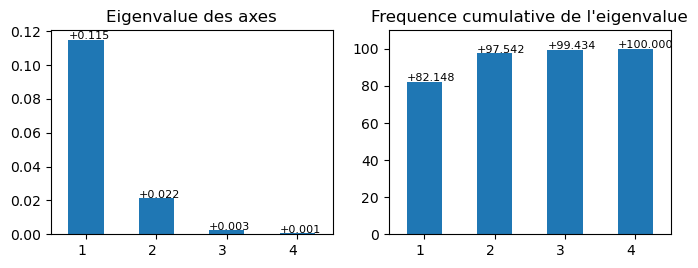

In [132]:
eig = pd.DataFrame(afc.eig_)

r1 = eig.iloc[0]
r2 = eig.iloc[2]
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

### https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
aa = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
for p in aa.patches:
    b = p.get_bbox()
    # print(b)
    val = "{:+.3f}".format(b.y1 + b.y0)    
    # print(b.x1)    
    aa.annotate(val, (b.x0 , b.y1* 1.005), size=8)
plt.margins(y = 0.1)

bb = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue")

for container in bb.containers:
    for p in bb.patches:
        b = p.get_bbox()
        # print(b)
        val = "{:+.3f}".format(b.y1 + b.y0)    
        # print(b.x1)    
        bb.annotate(val, (b.x0, b.y1* 1.005), size=8)


plt.margins(y = 0.1)
# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Distances des lignes / des colonnes

In [134]:
# Calcul des profils des lignes
prof_lig = np.apply_along_axis(arr=D.values,axis=1,
                               func1d=lambda x:x/np.sum(x))
# Calul du profil marginal correspondant
# Cf. ligne grisée de Figure 100, Rakotomalala, 2020
tot_col = ddf.loc['Total'][:5]
prof_marg_lig = tot_col/np.sum(tot_col)

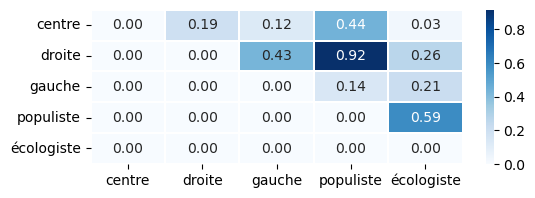

In [135]:
### Distance entre paires de modalités lignes,
# calculée sur la base des valeurs dans la note précédente

fig, ax = plt.subplots(figsize=(6,2))

distPairesLig = np.zeros(shape=(prof_lig.shape[0],prof_lig.shape[0]))
#double boucle
for i in range(prof_lig.shape[0]):
    for j in range(i+1,prof_lig.shape[0]):
        distPairesLig[i,j] = np.sum((prof_lig[i,:]-prof_lig[j,:])**2/prof_marg_lig)

sns.heatmap(distPairesLig,vmin=0,vmax=np.max(distPairesLig),linewidth=0.1,cmap=
'Blues',xticklabels=D.index,yticklabels=D.index,
fmt=".2f", annot=True)


### ATTENTION: plus la couleur est foncée, plus la distance est grande
plt.show()

In [136]:
# Profil marginal des filières (colonnes)
tot_lig = np.sum(D.values,axis=1)
prof_marg_col = tot_lig/np.sum(tot_lig)

# Tableau des profils colonnes
prof_col = np.apply_along_axis(arr=D.values,axis=0,
                               func1d=lambda x:x/np.sum(x))
#print(pd.DataFrame(prof_col,index=D.index,columns=D.columns))
### Transposer pour garder la structure du code Python des lignes 
t_prof_col = prof_col.T

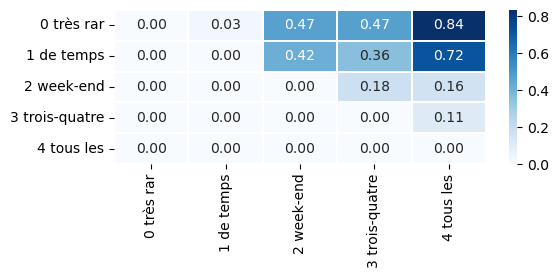

In [137]:
### Distance entre paires de modalités colonnes,
# calculée sur la base des valeurs précédentes  

fig, ax = plt.subplots(figsize=(6,2))


distPairesCol = np.zeros(shape=(t_prof_col.shape[0],
                                t_prof_col.shape[0]))
#double boucle
for i in range(t_prof_col.shape[0]-1):
    for j in range(i+1,t_prof_col.shape[0]):        
        distPairesCol[i,j] = np.sum((t_prof_col[i,:]-t_prof_col[j,:])**2/prof_marg_col)
#distPairesLig[j,i] = distPairesLig[i,j]
#affichage
#print(pd.DataFrame(distPairesLig,index=D.index,columns=D.index))

sns.heatmap(distPairesCol,vmin=0,vmax=np.max(distPairesCol),
            linewidth=0.1,cmap='Blues',xticklabels=D.columns,
            yticklabels=D.columns, 
fmt=".2f", annot=True)

plt.show()

### Graphiques et interprétation du premier plan factoriel

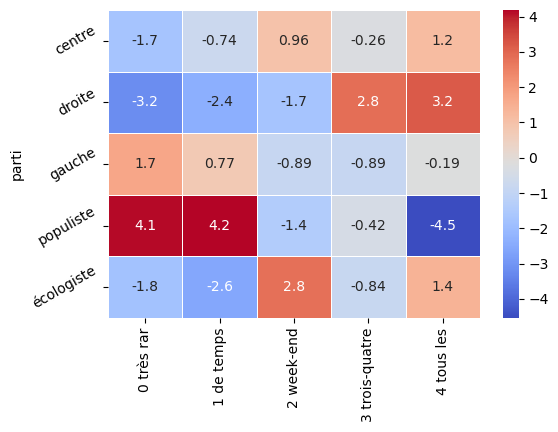

In [138]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(6,4))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labels = residus_ponderes.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()


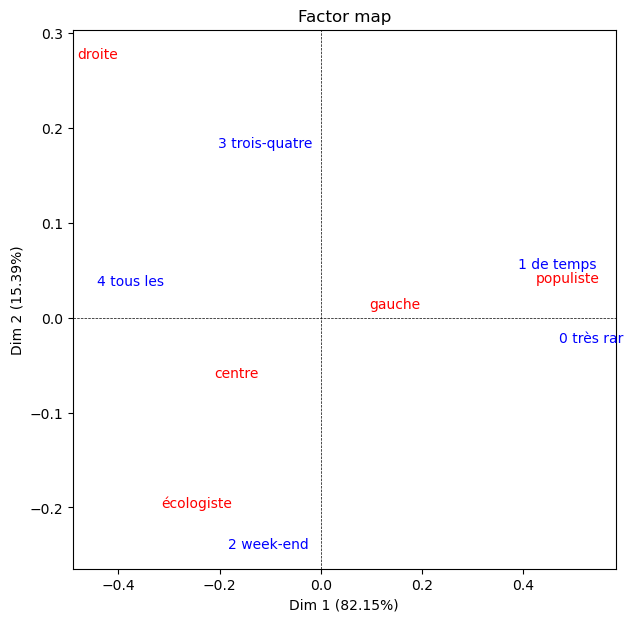

In [205]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(7,7))

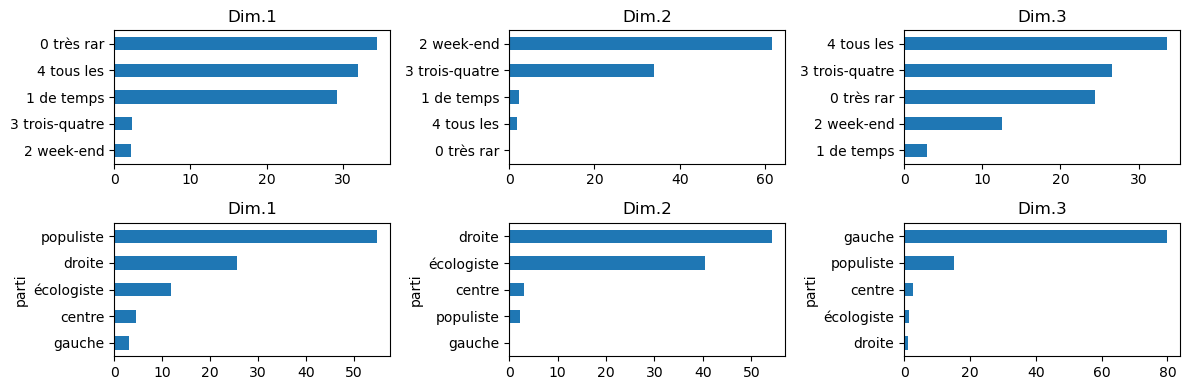

In [140]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()
